In [1]:
cd ..

/home/m13uz/groningen


In [2]:
import tensorflow as tf
import matplotlib
import numpy as np
import pandas as pd
import json
import os
import itertools
import functools
import data.helpers as helpers
import seaborn as sns
import matplotlib.pyplot as plt
from data.tile_creater import discretiser, grid_translation, get_pixel_lens

In [30]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
def plot_slice(tslice):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.heatmap(tslice, ax=ax)
    #ax.set_aspect('equal')
    #ax.scatter(quake_x,quake_y, marker='o', color = 'r', s=50)
    sns.despine()
    fig.tight_layout()
    #fig.savefig('inspecttile', dpi=600)

In [4]:
def binary_encode(i, num_digits):
    return np.array([i >> d & 1 for d in range(num_digits)])
def fizz_buzz_encode(i):
    if   i % 15 == 0: return 0#np.array([0, 0, 0, 1])
    elif i % 5  == 0: return 1 #np.array([0, 0, 1, 0])
    elif i % 3  == 0: return 2#np.array([0, 1, 0, 0])
    else:             return 3#np.array([1, 0, 0, 0])

def invert(label, sample):
    if label == 3:
        return sample
    else:
        return {0:'fizzbuzz', 1:'fizz',2:'buzz'}[label]
def generate_training(num_digits, therange):
    for i in range(*therange):
        yield binary_encode(i, num_digits)
names=[str(i) for i in range(12)]
train_x = pd.DataFrame((i for i in generate_training(12,(101,1024))), columns=names)
test_range = (0,100)
train_range = (101,1024)
train_y = np.asarray([fizz_buzz_encode(i) for i in range(*train_range)])
test_x = pd.DataFrame((i for i in generate_training(12,test_range)),columns=names)
test_y = np.asarray([fizz_buzz_encode(i) for i in range(*test_range)])

In [45]:
def get_fnames():
    prefix = 'data/tiles_small/'
    fnames = [prefix+i for i in os.listdir(prefix)
             if i.split('.')[-1] == 'txt']
    return fnames
def parse_filename(fname):
    no_prefix = fname.strip('data/tiles_small')
    eventid, seq_id = no_prefix.split('_')
    return eventid, int(seq_id.strip('.txt'))
def get_label(metadata, filename):
    eventid, seqid = parse_filename(filename)
    label = metadata[eventid]
    return label
def _format_label(eventlat,eventlon, eventdepth,
                  eventmag,eventid,topleft,
                  size_x,size_y,numx,numy, nonzeros):
    """
    Args: label is like (53.223, 6.949, 3.0, 0.502994544, 'knmi2018etrn',...)
    (oneevent['eventlat'],oneevent['eventlon']
            ,oneevent['eventdepth'], oneevent['magnitude']
            ,oneevent['eventid'], topleft, sizex, sizey, numx,numy)
    Returns: onehot tile encoding - numpy array
    """
    xy = grid_translation(topleft,eventlat,eventlon)
    plen_x, plen_y = get_pixel_lens(numx, numy, size_x, size_y)
    n,m = discretiser(plen_x,plen_y,xy)
    event_label_matrix = np.zeros((int(numy),int(numx)))
    try:
        event_label_matrix[m,n]=1.0
        event_label_matrix_flatten = event_label_matrix.flatten()
        if nonzeros>10:
            return event_label_matrix_flatten
    except IndexError:
        #earthquake was outside our grid if index error
        return
def format_frames(metadata,frames):
    """frames is a sequence of (eventid,seqnum,array)"""
    frame_group = list(frames)
    label = metadata[frames[0][0]]
    onehot = _format_label(*label)
    tensor_frames = np.dstack([np.loadtxt(frame[2]) 
                               for frame in frame_group])
    return tensor_frames, onehot
def gen(metadatafile,frames_per_eg, datafilenames):
    with open(metadatafile) as f:
        metadata = json.load(f)
    loaded_files = ((*parse_filename(fname),fname)
                    for fname in datafilenames) #np.loadtxt here in real execution
    sorted_by_event = sorted(loaded_files, key=lambda x:x[0])
    grouped_by_event = itertools.groupby(sorted_by_event, key = lambda x:x[0])
    inorder_by_event = (sorted(g, key = lambda x:x[1]) for k,g in grouped_by_event)
    window_groups_by_event = (helpers.grouper(frames_per_eg, group)
                              for group in inorder_by_event)
    formatted = (format_frames(metadata,framegroup) for framegroup
                 in itertools.chain(*window_groups_by_event))
    ingrid = ((tensor, label) for tensor, label
             in formatted if isinstance(label, np.ndarray))
    return ingrid
    #for idx, row in x.iterrows():
    #    data = np.asarray([row,
    #                       row])
    #    data = np.dstack((data,data, data))
    #    label = y[idx]
    #    yield data, label
def train_input_fn(metadatafile, train_filenames, batch_size=20, repeat=100):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    #dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))#.map(namer)
    dataset = tf.data.Dataset.from_generator(lambda: gen(metadatafile,10, train_filenames)
                                             ,output_types=(tf.int64, tf.int64)
                                             ,output_shapes = (tf.TensorShape([30,60,10]),
                                                               tf.TensorShape([1800]))
                                            )
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(100).repeat(repeat).batch(batch_size)
    # Return the dataset.
    iterator = dataset.make_one_shot_iterator()
    d,l = iterator.get_next()
    return {'image':d}, l
def test_input_fn(metadatafile, test_filenames, batch_size=1):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    #dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))#.map(namer)
    dataset = tf.data.Dataset.from_generator(lambda: gen(metadatafile,10, test_filenames)
                                             ,output_types=(tf.int64, tf.int64)
                                             ,output_shapes = (tf.TensorShape([30,60,10]),
                                                               tf.TensorShape([1800]))
                                            )
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(100)
    # Return the dataset.
    iterator = dataset.make_one_shot_iterator()
    d,l = iterator.get_next()
    return {'image':d}, l

In [46]:
def split_traintest(fnames, train_proportion):
    eventgetter = lambda f: parse_filename(f)[0]
    orderedbyevent = sorted(fnames, key = eventgetter) 
    groupedbyevent = [list(g) for k,g in
                      itertools.groupby(orderedbyevent, key = eventgetter)]
    numevents = len(groupedbyevent)
    n_training = int(numevents*train_proportion)
    train, test = groupedbyevent[0:n_training], groupedbyevent[n_training::]
    return list(itertools.chain(*train)), list(itertools.chain(*test))
train, test = split_traintest(get_fnames(), 0.8)

{'image': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0

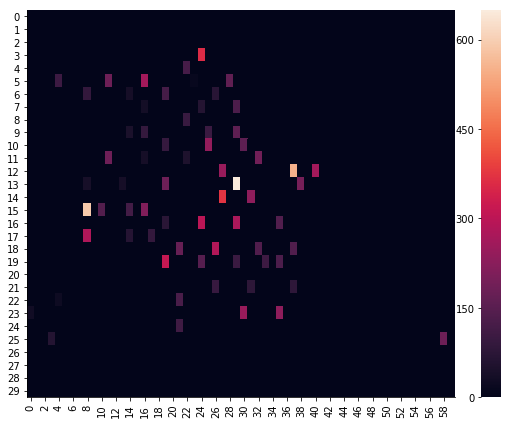

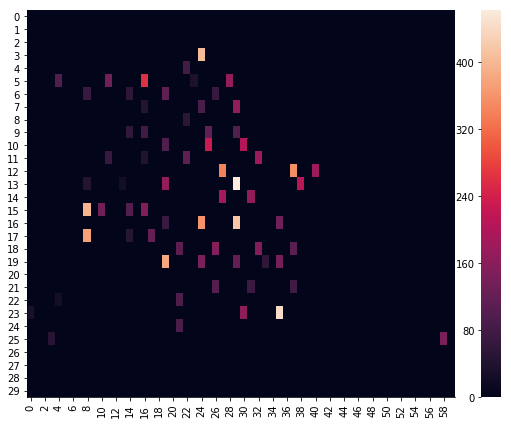

In [47]:
with tf.Session() as sess:
    n = test_input_fn('data/tiles_small/metadata.json',test)
    i, label = sess.run(n)
    print(i)
    for idx in range(2):
        print(np.shape(i['image']))
        sliced = i['image'][:,:,idx]
        print(np.shape(sliced))
        plot_slice(sliced)